In [1]:
import torch
import torch.nn as nn
import torchaudio
from pathlib import Path
import pandas as pd
import IPython.display as ipd
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class NSynthDataSet:
  def __init__(self, path):
    if isinstance(path, str):
      path = Path(path)
    self.path = path
    json_path = path / "examples.json"
    self.meta = pd.read_json(json_path).to_dict()

    
    self.file_list = list(self.path.rglob('*.wav'))
    
  def __getitem__(self, idx):
    fn = self.file_list[idx]
    audio, sr = torchaudio.load(fn)
    pitch = self.meta[fn.stem]['pitch']
    pitch_vec = torch.zeros(120)
    pitch_vec[pitch-1] = 1
    return audio, pitch_vec
  
  def __len__(self):
    return len(self.meta.keys())

dataset = NSynthDataSet(Path('../datasets/nsynth-train'))

In [3]:
testset = NSynthDataSet(Path('../datasets/nsynth-test'))

In [6]:
audio, label =dataset[600]
print(label)
ipd.Audio(audio, rate=16000)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [335]:
pitch_set = set([dataset.meta[key]['pitch'] for key in dataset.meta])

In [338]:
max(pitch_set)

120

In [7]:
train_loader = DataLoader(dataset, batch_size=128, num_workers=4)
test_loader = DataLoader(testset, batch_size=128, shuffle=False)
batch = next(iter(train_loader))
batch

[tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[ 7.6294e-04,  3.5706e-03,  8.8501e-03,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         ...,
 
         [[ 0.0000e+00,  0.0000e+00,  3.0518e-05,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[-3.6621e-04,  2.7466e-04, -1.5259e-04,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]])]

In [11]:
train_path = Path('../datasets/nsynth-train')
train_json = train_path/"examples.json"
df = pd.read_json(train_json)

In [14]:
dict_df = df.to_dict()

In [17]:
file_name_keys = dict_df.keys()
file_name_paths = train_path.rglob("*.wav")

for fn in file_name_paths:
  if fn.stem not in file_name_keys:
    print(fn)

In [12]:
class SpecModel(nn.Module):
  def __init__(self, n_fft, hop_length):
    super().__init__()
    self.mel_converter = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    self.db_converter = torchaudio.transforms.AmplitudeToDB()

  def forward(self, audio_sample):
    mel_spec = self.mel_converter(audio_sample)
    db_spec = self.db_converter(mel_spec)
    return db_spec

class Conv2dNormPool(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, padding, pool_size):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.activation = nn.ReLU()
    self.pool = nn.MaxPool2d(pool_size)
    
  def forward(self, x):
    x = self.conv(x)
    x = self.batch_norm(x)
    x = self.activation(x)
    return self.pool(x)
  
class Conv2dNormTransposePool(Conv2dNormPool):
  def __init__(self, in_channels, out_channels, kernel_size, padding, pool_size):
    super().__init__(in_channels, out_channels, kernel_size, padding, pool_size)
    self.conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
    self.pool = nn.Upsample(scale_factor=pool_size, mode='bilinear')
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.activation = nn.ReLU()

  
class AutoEncoder(nn.Module):
  def __init__(self, n_fft, hop_length, hidden_size=256):
    super().__init__()
    self.spec_model = SpecModel(n_fft, hop_length)
    self.encoder = nn.Sequential()
    self.num_channels = [1] + [hidden_size // 2**i for i in reversed(range(7))]
    for i in range(6):
      self.encoder.add_module(f"conv_norm{i}", Conv2dNormPool(self.num_channels[i], self.num_channels[i+1], (3,3), 1, (2,2) ))
    self.encoder.add_module(f"final_conv",nn.Conv2d(in_channels=self.num_channels[-2], out_channels=self.num_channels[-1], kernel_size=(3,3), padding=1))
#     self.encoder = nn.Sequential(
#       nn.Conv2d(in_channels=1, out_channels=hidden_size//64, kernel_size=(3,3), padding=1),
#       nn.ReLU(),
#       nn.MaxPool2d(2,2),
#       nn.Conv2d(in_channels=hidden_size//64, out_channels=hidden_size//32, kernel_size=(3,3), padding=1),
#       nn.ReLU(),
#       nn.MaxPool2d(2,2),
#       nn.Conv2d(in_channels=hidden_size//32, out_channels=hidden_size//16, kernel_size=(3,3), padding=1),
#       nn.ReLU(),
#       nn.MaxPool2d(2,2),
#       nn.Conv2d(in_channels=hidden_size//16, out_channels=hidden_size//8, kernel_size=(3,3), padding=1),
#       nn.ReLU(),
#       nn.MaxPool2d(2,2),
#       nn.Conv2d(in_channels=hidden_size//8, out_channels=hidden_size//4, kernel_size=(3,3), padding=1),
#       nn.ReLU(),
#       nn.MaxPool2d(2,2),
#       nn.Conv2d(in_channels=hidden_size//4, out_channels=hidden_size//2, kernel_size=(3,3), padding=1),
#       nn.ReLU(),
#       nn.MaxPool2d(2,2),
#       nn.Conv2d(in_channels=hidden_size//2, out_channels=hidden_size, kernel_size=(3,3), padding=1),
#     )
    self.final_layer = nn.Linear(hidden_size * 32, hidden_size) 
  
    self.decoder = nn.Sequential(      
#       nn.ConvTranspose2d(in_channels=hidden_size+120, out_channels=hidden_size//2, kernel_size=(8,4)),
#       nn.BatchNorm2d(hidden_size//2),
#       nn.Upsample(scale_factor=2, mode='bilinear'),
#       nn.ReLU(),
        Conv2dNormTransposePool(in_channels=self.num_channels[-1]+120, out_channels=self.num_channels[-2], kernel_size=(8,4), padding=0, pool_size=2)
    )
    for i in range(5):
      self.decoder.add_module(f"conv_norm{i}", Conv2dNormTransposePool(self.num_channels[-2-i], self.num_channels[-3-i], (3,3), 1, 2))
    self.decoder.add_module("final_module",  nn.ConvTranspose2d(in_channels=self.num_channels[1], out_channels=1, kernel_size=(3,3), padding=1),)
    
#     self.decoder = nn.Sequential(
#       nn.ConvTranspose2d(in_channels=hidden_size+120, out_channels=hidden_size//2, kernel_size=(8,4)),
#       nn.Upsample(scale_factor=2, mode='bilinear'),
#       nn.ReLU(),
#       nn.ConvTranspose2d(in_channels=hidden_size//2, out_channels=hidden_size//4, kernel_size=(3,3),  padding=1),
#       nn.Upsample(scale_factor=2, mode='bilinear'),
#       nn.ReLU(),
#       nn.ConvTranspose2d(in_channels=hidden_size//4, out_channels=hidden_size//8, kernel_size=(3,3),  padding=1),
#       nn.Upsample(scale_factor=2, mode='bilinear'),
#       nn.ReLU(),
#       nn.ConvTranspose2d(in_channels=hidden_size//8, out_channels=hidden_size//16, kernel_size=(3,3),  padding=1),
#       nn.Upsample(scale_factor=2, mode='bilinear'),
#       nn.ReLU(),
#       nn.ConvTranspose2d(in_channels=hidden_size//16, out_channels=hidden_size//32, kernel_size=(3,3),  padding=1),
#       nn.Upsample(scale_factor=2, mode='bilinear'),
#       nn.ReLU(),
#       nn.ConvTranspose2d(in_channels=hidden_size//32, out_channels=hidden_size//64, kernel_size=(3,3),  padding=1),
#       nn.Upsample(scale_factor=2, mode='bilinear'),
#       nn.ReLU(),
#       nn.ConvTranspose2d(in_channels=hidden_size//64, out_channels=1, kernel_size=(3,3), padding=1),
#     )
    
  def forward(self, x, pitch):
    spec = self.spec_model(x)
    spec = spec[:,:,:-1] # to match 512
    spec /= 80
    spec = nn.functional.pad(spec, (2,3), value=torch.min(spec))
    out = self.encoder(spec)
    latent = self.final_layer(out.view(out.shape[0], -1))
    latent = torch.cat([latent, pitch], dim=-1)
    latent = latent.view(latent.shape[0], -1, 1, 1)
    recon_spec = self.decoder(latent)
    return recon_spec, spec
  
model = AutoEncoder(1024, 256, 256)
recon_spec, spec = model(audio.unsqueeze(0), torch.zeros(audio.shape[0], 120))
recon_spec.shape, spec.shape

(torch.Size([1, 1, 512, 256]), torch.Size([1, 1, 512, 256]))

In [13]:
model.load_state_dict(torch.load('note_autoencoder.pt'))

<All keys matched successfully>

In [390]:
model.conv_2d= nn.ConvTranspose2d(in_channels=256+120, out_channels=256//2, kernel_size=(8,4), padding=1)

In [392]:
model.conv_2d(torch.zeros(1,376,1,1)).shape

torch.Size([1, 128, 6, 2])

In [365]:
model.decoder

Sequential(
  (0): ConvTranspose2d(376, 128, kernel_size=(8, 4), stride=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Upsample(scale_factor=2.0, mode=bilinear)
  (3): ReLU()
  (conv_norm0): Conv2dNormTransposePool(
    (conv): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (pool): Upsample(size=2, mode=bilinear)
  )
  (conv_norm1): Conv2dNormTransposePool(
    (conv): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (pool): Upsample(size=2, mode=bilinear)
  )
  (conv_norm2): Conv2dNormTransposePool(
    (conv): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(16, eps=1e-0

In [153]:
def train_loss(pred, target):
  return torch.mean((pred-target)**2)

In [411]:
def train_model(model, loader, optimizer, n_epochs, loss_func, device):
  model.train()
  model = model.to(device)
  loss_record = []
  for epoch in tqdm(range(n_epochs)):
    for batch in loader:
      optimizer.zero_grad()
      audio, pitch = batch
      pred, spec = model(audio.to(device), pitch.to(device))
      loss = loss_func(pred, spec)
      loss.backward()
      optimizer.step()
      loss_record.append(loss.item())
  return loss_record
    
model = AutoEncoder(1024, 256, 256)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_record = train_model(model, train_loader, optimizer, 10, train_loss, device='cuda')
torch.save(model.state_dict(), 'note_autoencoder.pt')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [46:54<00:00, 281.49s/it]


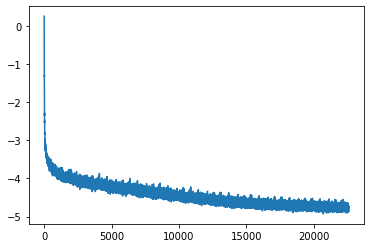

In [412]:
from math import log
plt.plot([log(x) for x in loss_record])

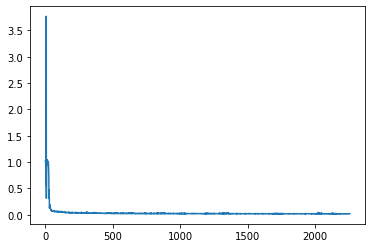

In [279]:
plt.plot(loss_record)

In [162]:
len(dataset) // 64

4518

In [15]:
model = model.cuda()

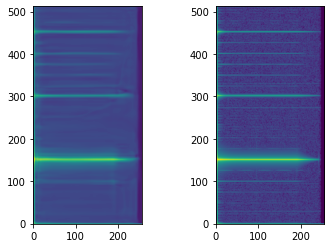

In [24]:

batch = next(iter(test_loader))
model.eval()
with torch.no_grad():
  pred, spec = model(batch[0].to("cuda"), batch[1].to("cuda"))
pred = pred.cpu() * 80
spec = spec.cpu() * 80
pred = nn.functional.pad(pred, (0,0,1,0))
spec = nn.functional.pad(spec, (0,0,1,0))
plt.subplot(1,2,1)
plt.imshow(pred[4,0], origin='lower')
plt.subplot(1,2,2)
plt.imshow(spec[4,0], origin='lower')


In [210]:
pred[0,0]

tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [ -0.9750,  -7.7809, -11.5394,  ..., -25.1075, -12.3827,   4.8733],
        [  2.0553,  -4.6688,  -8.5833,  ...,   0.7779,   0.5473,  -1.4129],
        ...,
        [ -1.7136, -18.5245, -37.5037,  ..., -14.0435,   2.3857,  -5.5026],
        [ -3.0758, -21.1310, -37.1924,  ..., -13.8113,   8.0270,  -4.7151],
        [ -7.7941, -22.2112, -41.9923,  ..., -35.1141, -15.4946, -28.3659]])

In [17]:
amplitude_spec = torchaudio.functional.DB_to_amplitude(pred, ref=1, power=0.5)
amplitude_orig_spec = torchaudio.functional.DB_to_amplitude(spec, ref=1, power=0.5)
griffin_lim = torchaudio.transforms.GriffinLim(n_fft=1024, hop_length=256, n_iter=30)
audio_samples = griffin_lim(amplitude_spec)
orig_recon_audio_samples = griffin_lim(amplitude_orig_spec)

In [21]:
ipd.Audio(audio_samples[0], rate=16000)

In [19]:
ipd.Audio(orig_recon_audio_samples[0], rate=16000)

In [20]:
ipd.Audio(batch[0][0], rate=16000)

In [26]:
sounds, pitches = batch

In [112]:
sound_a = sounds[0:1]
sound_b = sounds[40:41]
pitch = pitches[0:1]

In [28]:
pitch

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [113]:
def get_embedding(self, x):
  spec = self.spec_model(x)
  spec = spec[:,:,:-1] # to match 512
  spec /= 80
  spec = nn.functional.pad(spec, (2,3), value=torch.min(spec))
  out = self.encoder(spec)
  latent = self.final_layer(out.view(out.shape[0], -1))
  return latent

emb_a = get_embedding(model, sound_a.cuda())
emb_b = get_embedding(model, sound_b.cuda())
emb_a.shape, emb_b.shape

(torch.Size([1, 256]), torch.Size([1, 256]))

In [114]:
ipd.Audio(sound_a[0], rate=16000)

In [115]:
ipd.Audio(sound_b[0], rate=16000)

In [116]:
mixed_embedding = (emb_a + emb_b) /2

In [117]:
def decode_from_embedding(self, latent, pitch):
  with torch.no_grad():
    latent = torch.cat([latent, pitch], dim=-1)
    latent = latent.view(latent.shape[0], -1, 1, 1)
    recon_spec = self.decoder(latent)
    return recon_spec

recon_spec = decode_from_embedding(model, mixed_embedding, pitch.cuda())
recon_spec = nn.functional.pad(recon_spec, (0,0,1,0))
recon_spec = recon_spec.cpu() * 80


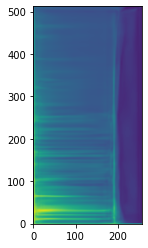

In [118]:
plt.imshow(recon_spec[0,0].detach().cpu(), origin='lower')

In [119]:
amp_recon_spec = torchaudio.functional.DB_to_amplitude(recon_spec.cpu(), ref=0.4, power=0.5)
griffin_lim = torchaudio.transforms.GriffinLim(n_fft=1024, hop_length=256, n_iter=100)
recon_audio = griffin_lim(amp_recon_spec)
ipd.Audio(recon_audio[0], rate=16000)

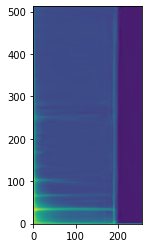

In [77]:
plt.imshow(amp_recon_spec[0,0].detach().cpu(), origin='lower')

In [54]:
audio_samples.shape

torch.Size([1, 1, 65280])